In [1]:
from AIP_interaction_map.asc import calculate_association_energy as ac
from AIP_interaction_map.asc import calculate_binding_energy as bc
from AIP_interaction_map.asc import calculate_solvation_energy as sc
from AIP_interaction_map.PDB_preprocess import PDB_preprocess 
from AIP_interaction_map.getScoring import Scoring
from AIP_interaction_map.scoring_traj_hg import ScoringTraj
from AIP_interaction_map.create_jmol_vis import create_jmol_vis
from AIP_interaction_map.create_jmol_vis import create_ip_vis
from AIP_interaction_map.get_desolvation import get_desolvated_AIPs, get_free_energy_of_solvation
from time import time
import mdtraj as md
import pandas as pd
import numpy as np
import os

# Protein-ligand complexes

In [15]:
PL = [
"1bcu","1e66","1g2k","1nc1","1nc3","1pxn","1qkt","1r5y","1s38","1z95","2br1","2brb","2c3i","2cet","2fxs","2iwx",
"2pog","2p15","2qe4","2v00","2vvn","2w4x","2wbg","2wca","2wn9","2xdl","2yki","3ao4","3aru","3arv","3ary","3b1m",
"3b27","3b5r","3b65","3b68","3e92","3fur","3g0w","3g2n","3g2z","3gnw","3gr2","3jvr","3jvs","3jya","3k5v","3kr8",
"3l7b","3o9i","3p5o","3prs","3pyy","3rlr","3rr4","3rsx","3syr","3u5j","3wz8","3wtj","4bkt","4cr9","4cra","4de1",
"4de3","4dli","4eky","4f9w","4gfm","4hge","4ih5","4ih7","4ivb","4ivc","4ivd",#"4j21","4j3l",
"4k18","4k77","4kzq","4kzu","4llx","4lzs","4m0y","4m0z","4mgd","4qac","4qd6","4rfm","4twp","4w9c","4w9h","4w9i","5c28"]

In [13]:
PL = [
"ADQPTFQIHHBGTE-UHFFFAOYSA-N","BPBBEBGGGQEHFN-UHFFFAOYSA-N","BPIJWWAOPXZGJB-UHFFFAOYSA-N",
"BTUJCHUIIMIJSY-UHFFFAOYSA-N","CSNZQZRMTZORRS-UHFFFAOYSA-N","GPZXMXXTXHYWJM-UHFFFAOYSA-N",
"GWNOZDUVSICZMK-UHFFFAOYSA-N","HCSXSWQRQHNATE-UHFFFAOYSA-N","HGNAWYKFKAMRLN-UHFFFAOYSA-N",
"IITDSYICYIVZSK-UHFFFAOYSA-N","ISZCBHHDHSQMRQ-UHFFFAOYSA-N","IVXGFXACZQBKSB-UHFFFAOYSA-N",
"KQGTYXRWSIBDOZ-UHFFFAOYSA-N","LFSVEOJOZMOINM-UHFFFAOYSA-N","MCPINKCJNXYHSN-UHFFFAOYSA-N",
"MYFOTLHQMXVWQX-UHFFFAOYSA-N","NNVGKBYGEXMXGT-UHFFFAOYSA-N","ORPLKVBNBJSMGV-UHFFFAOYSA-N",
"PGOJQQUKXOHEMO-UHFFFAOYSA-N","PGWONMQJDLBWPO-UHFFFAOYSA-N","PNDYXOWYKQCCQE-UHFFFAOYSA-N",
"PNEWIQAEGKQNCE-UHFFFAOYSA-N","PUNOHVAFQIIDRY-UHFFFAOYSA-N","QTFCKBFCXDAZIU-UHFFFAOYSA-N",
"QVUBWOXHCKFOHM-UHFFFAOYSA-N","SOFXCIXLIWYDGQ-UHFFFAOYSA-N","SQWQKIUENAZSAY-UHFFFAOYSA-N",
"TZDOGRLWMMRMCR-UHFFFAOYSA-N","TZHCXOMEOHEZDX-UHFFFAOYSA-N","UPLMGYPCFPKZEU-UHFFFAOYSA-N",
"VBRHQHDVIDGQES-UHFFFAOYSA-N","VPEQURIWBMCLKC-UHFFFAOYSA-N","YIDPUNRWTJXITE-UHFFFAOYSA-N",
"YNUBXRLSUZAOAE-UHFFFAOYSA-N","ZCOJEMMXFPJJRU-UHFFFAOYSA-N","ZPZZWCZJGVDHOW-UHFFFAOYSA-N",
"ZSSACRPYNVFTRY-UHFFFAOYSA-N","ZVQZIVCQLFGXFZ-UHFFFAOYSA-N"]

In [20]:
comps = ["ligand_modified", "binding_site"]
for i,l in enumerate(PL):
        #path = f"/home/kate/workspace/EPHB4/{l}/"
        path = f"/home/kate/workspace/hunter_scoring/input_data/{l}"
        PDB_file1 = f"{path}/{comps[0]}.pdb"
        PDB_file2 = f"{path}/{comps[1]}.pdb"
        #PDB_file2 = f"/home/kate/workspace/EPHB4/{comps[1]}.pdb"
        self = Scoring(PDB_file1, PDB_file2, protein_host=True, max_aip_dist=0.17, solvent="water")
        #self.interaction_df = self.non_polar_df
        frac = self.interaction_df.Frac
        dG1 = sum([i for i in self.interaction_df.ddG_sc if i < 5])
        frac = self.interaction_df.Frac
        dG3 = sum([j[10]*j[9]*j[6] for _,j in self.interaction_df.iterrows()])
        dG4 = sum([-sc(j[10], None, "water")*frac[i] for i,j in self.interaction_df.iterrows()])
        dG6 = sum([sc(j[10], None, "noble")*frac[i] for i,j in self.interaction_df.iterrows()])
        #print(dG1, dG3, dG4+dG6)
        TAB = "\\begin{table}[H]\n\\centering\n\\begin{tabular}{p{0.05\\textwidth}p{0.12\\textwidth}p{0.11\\textwidth}p{0.05\\textwidth}p{0.11\\textwidth}p{0.09\\textwidth}p{0.05\\textwidth}p{0.1\\textwidth}}\nGuest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \\textit{f} & $\Delta\Delta G$ (kJ/mol) \\\\\n"
        for row in self.interaction_df.values.tolist():
            TAB += f"{int(row[0])} & {row[7]} & {round(row[9],2)} & {int(row[1])} & {row[8]} & {round(row[10],2)} & {row[6]} & {round(row[12],2)} \\\\\n"   
        TAB += "\end{tabular}\n\caption{l protein-ligand complex}\n\label{A5:it}\n\end{table}\n"
        print(TAB)

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
5 & C.ar & -1.59 & 643 & H.soft & 0.34 & 0.5 & -1.71 \\
20 & H.soft & 0.99 & 639 & C.2 & -0.5 & 0.5 & -1.72 \\
7 & C.ar & -1.64 & 646 & H.soft & 0.34 & 0.5 & -1.68 \\
8 & C.ar & -1.42 & 642 & H.soft & 1.11 & 0.5 & -1.51 \\
11 & C.ar & -1.42 & 642 & H.soft & 1.11 & 0.5 & -1.51 \\
13 & C.ar & -2.77 & 633 & N.pl3.am & -0.48 & 0.5 & -0.39 \\
2 & C.ar & -1.72 & 590 & C.2 & -1.76 & 0.5 & -0.52 \\
3 & C.ar & -3.14 & 591 & O.2.am & -1.35 & 0.5 & 0.62 \\
9 & N.ar & -2.64 & 617 & H.soft & 0.64 & 0.5 & -0.98 \\
10 & C.ar & -2.99 & 617 & H.soft & 0.64 & 0.5 & -0.68 \\
12 & C.ar & -1.45 & 613 & C.2 & -1.76 & 0.5 & -0.74 \\
0 & C.ar & -1.98 & 897 & H.soft & 1.11 & 0.5 & -1.3 \\
1 & C.ar & -2.01 & 

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
0 & N.ar & 1.42 & 646 & C.ar & -1.53 & 0.5 & -1.22 \\
1 & C.ar & -1.34 & 650 & H.soft & 0.64 & 0.5 & -1.78 \\
4 & C.ar & 0.68 & 654 & H.soft & 0.71 & 0.5 & -1.56 \\
5 & C.ar & 0.42 & 648 & C.ar & -1.56 & 0.5 & -1.72 \\
7 & N.ar.no_lp & -0.23 & 654 & H.soft & 0.71 & 0.5 & -1.93 \\
8 & N.ar & 0.63 & 1449 & C.ar & -1.55 & 0.5 & -1.69 \\
21 & H.N & 3.03 & 691 & O.2.am & -7.73 & 0.5 & -0.31 \\
21 & H.N & 3.03 & 688 & N.pl3.am & -0.38 & 0.5 & 1.71 \\
1 & C.ar & -1.84 & 914 & C.2 & -2.23 & 0.5 & 0.01 \\
2 & N.ar & -1.45 & 921 & H.soft & 1.11 & 0.5 & -1.5 \\
2 & N.ar & -5.49 & 963 & H.soft & 0.65 & 0.5 & 2.0 \\
2 & N.ar & -0.25 & 957 & S.3 & 0.0 & 0.5 & -2.2 \\
3 & C.ar & -1.58 & 921 & H.sof

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
1 & C.ar & -1.82 & 337 & C.ar & -1.52 & 0.5 & -0.63 \\
3 & C.ar & -1.7 & 335 & C.ar & -1.42 & 0.5 & -0.81 \\
0 & C.ar & -1.98 & 339 & C.ar & -1.53 & 0.5 & -0.48 \\
5 & C.ar & -1.13 & 343 & H.soft & 0.51 & 0.5 & -1.9 \\
8 & C.ar & -2.03 & 713 & H.soft & 0.94 & 0.5 & -1.35 \\
1 & C.ar & -1.84 & 1294 & H.soft & 0.53 & 0.5 & -1.55 \\
16 & H.soft & 0.52 & 1299 & H.soft & 0.81 & 0.5 & -1.59 \\
16 & H.soft & 0.52 & 240 & O.2.other & -0.1 & 0.5 & -2.04 \\
3 & C.ar & -1.53 & 1290 & S.3 & -3.5 & 0.5 & 1.19 \\
5 & C.ar & -0.85 & 803 & H.soft & 0.34 & 0.5 & -2.02 \\
7 & N.ar.no_lp & 0.59 & 807 & H.soft & 0.33 & 0.5 & -1.88 \\
8 & C.ar & -2.3 & 1290 & S.3 & -3.5 & 0.5 & 1.85 \\
10 & C.ar & -1.84 

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
32 & H.soft & 1.51 & 1539 & C.2 & -0.5 & 0.5 & -1.13 \\
5 & C.ar & -0.13 & 1510 & H.soft & 0.33 & 0.5 & -2.12 \\
7 & C.ar & -1.26 & 1543 & H.soft & 0.49 & 0.5 & -1.85 \\
9 & N.ar.no_lp & -0.11 & 1510 & H.soft & 0.33 & 0.5 & -2.12 \\
9 & N.ar.no_lp & -0.48 & 360 & H.soft & 0.33 & 0.5 & -2.1 \\
8 & N.ar & 0.09 & 360 & H.soft & 0.33 & 0.5 & -2.12 \\
15 & C.ar & -1.29 & 357 & H.soft & 0.33 & 0.5 & -1.87 \\
19 & C.ar & -1.2 & 1355 & H.soft & 0.33 & 0.5 & -1.9 \\
18 & C.ar & -1.34 & 1355 & H.soft & 0.33 & 0.5 & -1.84 \\
11 & N.ar & -1.52 & 1534 & N.pl3.am & -0.48 & 0.5 & -1.53 \\
12 & C.ar & -2.25 & 1505 & H.soft & 0.22 & 0.5 & -1.24 \\
18 & C.ar & -1.96 & 545 & H.soft & 0.49 & 0.5 & -1.48

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
7 & C.ar & -1.95 & 899 & H.soft & 0.33 & 0.5 & -1.48 \\
8 & C.ar & -1.75 & 894 & H.soft & 0.33 & 0.5 & -1.62 \\
10 & C.ar & -1.9 & 894 & H.soft & 0.33 & 0.5 & -1.52 \\
6 & C.ar & -1.99 & 491 & H.soft & 0.49 & 0.5 & -1.46 \\
37 & H.soft & 0.61 & 351 & H.soft & 0.33 & 0.5 & -1.86 \\
37 & H.soft & 0.61 & 343 & C.2 & -1.76 & 0.5 & -1.59 \\
40 & H.soft & 0.88 & 344 & O.2.am & -1.35 & 0.5 & -1.67 \\
26 & C.ar & -0.71 & 1766 & H.soft & 0.68 & 0.5 & -1.93 \\
23 & C.ar & -0.71 & 358 & H.soft & 0.34 & 0.5 & -2.06 \\
55 & H.soft & 1.09 & 271 & S.3 & 0.0 & 0.5 & -1.59 \\
29 & F & 0.0 & 1754 & C.ar & -1.52 & 0.5 & -1.75 \\
7 & C.ar & -2.17 & 458 & H.soft & 0.34 & 0.5 & -1.32 \\
8 & C.ar & -2.06 &

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
12 & C.2 & 0.34 & 612 & C.ar & -1.44 & 0.5 & -1.79 \\
14 & N.pl3.am & 2.12 & 614 & C.ar & -1.32 & 0.5 & -0.36 \\
31 & H.soft & 1.25 & 610 & C.ar & -1.45 & 0.5 & -1.39 \\
31 & H.soft & 1.25 & 862 & H.soft & 0.39 & 0.5 & -1.18 \\
16 & N.2 & -1.06 & 453 & C.2 & -0.5 & 0.5 & -1.8 \\
32 & H.soft & 1.2 & 1012 & C.ar & -1.82 & 0.5 & -1.32 \\
32 & H.soft & 1.2 & 1014 & C.ar & -1.67 & 0.5 & -1.37 \\
12 & C.2 & -0.37 & 1016 & C.ar & -1.87 & 0.5 & -1.32 \\
14 & N.pl3.am & 1.44 & 1018 & C.ar & -1.96 & 0.5 & -1.09 \\
30 & H.soft & 1.29 & 521 & S.3 & 0.0 & 0.5 & -1.35 \\
30 & H.soft & 1.29 & 521 & S.3 & -3.32 & 0.5 & -0.48 \\
22 & H.soft & 0.76 & 1130 & C.2 & -1.66 & 0.5 & -1.6 \\
24 & H.soft & 0.

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
14 & C.ar & -0.86 & 2046 & C.ar & -1.82 & 0.5 & -1.09 \\
15 & C.ar & -0.86 & 2048 & C.ar & -1.67 & 0.5 & -1.22 \\
2 & C.ar & -2.08 & 2174 & C.ar & -1.56 & 0.5 & -0.37 \\
35 & H.soft & 1.23 & 1194 & H.soft & 1.11 & 1.0 & -1.03 \\
32 & C.ar & -1.58 & 579 & N.pl3.am & -0.38 & 0.5 & -1.53 \\
22 & C.ar & -0.68 & 1689 & C.ar & -1.56 & 0.5 & -1.4 \\
25 & C.ar & -2.35 & 1687 & C.ar & -1.53 & 0.5 & -0.12 \\
45 & H.soft & 1.0 & 1685 & C.ar & -1.44 & 0.5 & -1.57 \\
45 & H.soft & 1.0 & 1686 & C.ar & -1.52 & 0.5 & -1.55 \\
38 & H.N & 2.73 & 985 & S.3 & -3.5 & 1.0 & 0.08 \\
19 & C.ar & -0.54 & 985 & S.3 & -3.5 & 0.5 & 0.51 \\
6 & C.ar & -0.05 & 1306 & H.soft & 0.33 & 0.5 & -2.12 \\
22 & C.ar & 0.1

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
3 & C.ar & -0.08 & 1126 & N.pl3.primary & -0.1 & 0.5 & -2.18 \\
0 & C.ar & -0.1 & 341 & C.ar & -1.57 & 0.5 & -1.65 \\
1 & C.ar & -0.08 & 342 & C.ar & -1.53 & 0.5 & -1.68 \\
2 & C.ar & 0.06 & 345 & C.ar & -1.67 & 0.5 & -1.65 \\
3 & C.ar & -0.05 & 343 & C.ar & -1.82 & 0.5 & -1.49 \\
4 & C.ar & -0.38 & 346 & C.ar & -1.98 & 0.5 & -1.22 \\
5 & C.ar & -0.38 & 351 & H.soft & 0.49 & 0.5 & -2.05 \\
6 & C.ar & 0.43 & 344 & N.ar.no_lp & -1.17 & 0.5 & -1.9 \\
7 & C.ar & -0.34 & 347 & C.ar & -1.87 & 0.5 & -1.33 \\
9 & C.2 & -1.37 & 349 & C.ar & -1.96 & 0.5 & -0.62 \\
7 & C.ar & -0.76 & 928 & C.ar & -1.99 & 0.5 & -1.01 \\
9 & C.2 & -1.95 & 926 & C.ar & -1.98 & 0.5 & -0.12 \\
21 & H.soft & 0.93 & 9

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
37 & H.soft & 1.45 & 852 & N.pl3.am & -0.38 & 0.5 & -1.19 \\
37 & H.soft & 1.45 & 797 & C.ar & -1.57 & 0.5 & -1.18 \\
2 & I & -1.95 & 949 & O.2.am & -1.35 & 0.5 & -0.65 \\
2 & I & -1.95 & 1098 & H.soft & 0.51 & 0.5 & -1.48 \\
3 & C.ar & 0.4 & 952 & S.3 & -3.5 & 0.5 & -0.09 \\
4 & C.1 & -2.01 & 956 & H.soft & 0.53 & 0.5 & -1.44 \\
4 & C.1 & -1.68 & 1101 & H.soft & 0.65 & 0.5 & -1.62 \\
5 & N.1 & -2.11 & 956 & H.soft & 0.53 & 0.5 & -1.38 \\
5 & N.1 & -2.23 & 1098 & H.soft & 0.51 & 0.5 & -1.29 \\
6 & C.ar & 0.3 & 952 & S.3 & -3.5 & 0.5 & -0.04 \\
7 & C.ar & 0.32 & 450 & H.soft & 0.76 & 0.5 & -1.76 \\
26 & H.soft & 1.58 & 419 & H.soft & 0.19 & 0.5 & -0.83 \\
26 & H.soft & 1.58 & 562 & C.

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
1 & C.ar & 1.41 & 1683 & C.ar & -1.44 & 0.5 & -1.25 \\
2 & C.ar & 1.52 & 1685 & C.ar & -1.53 & 0.5 & -1.12 \\
10 & O.2.sulfone & -1.1 & 1740 & H.soft & 0.84 & 1.0 & -3.53 \\
19 & C.ar & -0.9 & 968 & H.soft & 0.34 & 0.5 & -2.01 \\
17 & C.ar & 1.14 & 502 & S.3 & -3.32 & 0.5 & -0.48 \\
19 & C.ar & 0.99 & 502 & S.3 & -3.32 & 0.5 & -0.46 \\
24 & C.ar & -1.14 & 481 & C.2 & -1.76 & 0.5 & -0.97 \\
30 & C.ar & -1.16 & 484 & H.soft & 0.88 & 0.5 & -1.73 \\
38 & H.soft & 1.21 & 497 & N.pl3.am & -0.38 & 0.5 & -1.49 \\
12 & C.ar & -0.8 & 920 & H.soft & 0.94 & 0.5 & -1.75 \\
13 & C.ar & 0.7 & 505 & H.soft & 0.97 & 0.5 & -1.29 \\
3 & C.ar & 1.84 & 368 & H.soft & 0.33 & 0.5 & -0.29 \\
4 & Cl & 0.47 &

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
11 & N.ar.no_lp & 0.04 & 579 & H.soft & 0.65 & 0.5 & -1.96 \\
12 & N.ar & -2.84 & 579 & H.soft & 0.65 & 0.5 & -0.81 \\
18 & H.soft & 0.6 & 764 & C.ar & -1.45 & 0.5 & -1.74 \\
18 & H.soft & 0.6 & 763 & C.ar & -1.42 & 0.5 & -1.76 \\
9 & C.ar & -3.12 & 584 & H.soft & 0.33 & 0.5 & -0.46 \\
7 & N.ar.no_lp & -1.6 & 900 & N.pl3.am & -0.38 & 0.5 & -1.52 \\
10 & N.ar & -1.47 & 877 & H.soft & 0.38 & 0.5 & -1.77 \\
5 & C.ar & -0.02 & 876 & H.soft & 1.11 & 0.5 & -1.54 \\
12 & N.ar & -3.23 & 615 & H.N & 2.84 & 1.0 & 0.28 \\
10 & N.ar & -2.24 & 906 & H.N & 2.84 & 1.0 & 0.82 \\
\end{tabular}
\caption{l protein-ligand complex}
\label{A5:it}
\end{table}

\begin{table}[H]
\centering
\begin{tabular}{p{

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
0 & N.ar.no_lp & 1.3 & 1375 & H.soft & 0.51 & 0.5 & -1.03 \\
1 & C.ar & 0.09 & 1367 & C.ar & -1.42 & 0.5 & -1.81 \\
10 & C.ar & 0.4 & 286 & H.soft & 0.64 & 0.5 & -1.8 \\
11 & C.ar & 0.24 & 1380 & H.soft & 0.7 & 0.5 & -1.84 \\
12 & C.ar & 0.36 & 286 & H.soft & 0.64 & 0.5 & -1.83 \\
18 & C.ar & 0.53 & 1368 & C.ar & -1.45 & 0.5 & -1.76 \\
4 & C.ar & -1.08 & 967 & C.2 & -1.76 & 0.5 & -1.01 \\
17 & S.3 & -2.69 & 979 & H.soft & 0.5 & 0.5 & -0.92 \\
17 & S.3 & -2.69 & 1017 & N.pl3.am & -0.38 & 0.5 & -0.54 \\
17 & S.3 & -2.74 & 1073 & H.soft & 0.49 & 0.5 & -0.87 \\
17 & S.3 & -2.74 & 1758 & H.soft & 0.34 & 0.5 & -0.84 \\
17 & S.3 & 0.0 & 1020 & O.2.am & -1.35 & 0.5 & -1.84 \\
30 & H.soft & 0

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
7 & C.2 & -1.8 & 893 & H.soft & 0.69 & 0.5 & -1.55 \\
9 & N.pl3.am & -0.36 & 893 & H.soft & 0.69 & 0.5 & -1.95 \\
66 & H.soft & 0.8 & 1744 & C.ar & -1.56 & 0.5 & -1.63 \\
53 & H.soft & 0.91 & 890 & H.soft & 1.11 & 1.0 & -1.83 \\
56 & H.soft & 1.26 & 1933 & O.3.alcohol & -5.34 & 0.5 & 1.1 \\
56 & H.soft & 1.26 & 1851 & O.2.other & -5.5 & 0.5 & 1.24 \\
60 & H.soft & 0.77 & 2289 & H.soft & 0.34 & 0.5 & -1.74 \\
60 & H.soft & 0.77 & 1937 & H.O & 2.85 & 0.5 & 2.21 \\
80 & H.soft & 0.43 & 1940 & H.soft & 0.39 & 0.5 & -1.94 \\
80 & H.soft & 0.43 & 1937 & H.O & 2.85 & 0.5 & 1.88 \\
19 & C.ar & -2.24 & 2219 & H.soft & 0.33 & 0.5 & -1.27 \\
69 & H.soft & 0.9 & 885 & C.ar & -1.52 & 0.5 & -1.6 \

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
4 & C.ar & -1.76 & 629 & H.soft & 1.17 & 0.5 & -1.36 \\
14 & C.ar & -1.75 & 611 & N.pl3.am & -0.38 & 0.5 & -1.41 \\
25 & H.soft & 1.31 & 570 & C.2 & -1.76 & 0.5 & -1.26 \\
25 & H.soft & 1.31 & 577 & H.soft & 0.64 & 0.5 & -0.91 \\
6 & N.ar & -0.73 & 148 & O.2.other & -0.1 & 0.5 & -2.06 \\
8 & C.ar & -1.25 & 436 & C.ar & -1.32 & 0.5 & -1.23 \\
2 & C.ar & -1.72 & 432 & C.ar & -1.45 & 0.5 & -0.77 \\
3 & C.ar & -1.71 & 439 & H.soft & 0.51 & 0.5 & -1.63 \\
4 & C.ar & -1.77 & 439 & H.soft & 0.51 & 0.5 & -1.6 \\
13 & C.ar & -1.71 & 431 & C.ar & -1.42 & 0.5 & -0.81 \\
14 & C.ar & -1.77 & 367 & O.2.am & -1.35 & 0.5 & -0.81 \\
16 & H.soft & 1.04 & 433 & C.ar & -1.52 & 0.5 & -1.52 \\
16 & H.soft

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
1 & C.ar & -2.17 & 941 & C.ar & -1.32 & 0.5 & -0.46 \\
3 & O.2.one_lp & -3.53 & 1068 & H.soft & 1.27 & 0.5 & -0.34 \\
3 & O.2.one_lp & -2.12 & 616 & H.soft & 0.69 & 0.5 & -1.36 \\
3 & O.2.one_lp & -2.12 & 1068 & H.soft & 1.27 & 0.5 & -1.15 \\
4 & C.ar & -1.79 & 937 & C.ar & -1.45 & 0.5 & -0.71 \\
6 & C.2 & -2.03 & 948 & H.soft & 0.94 & 0.5 & -1.35 \\
17 & C.ar & -3.41 & 939 & C.ar & -1.44 & 0.5 & 1.01 \\
23 & H.soft & 1.12 & 479 & C.ar & -1.96 & 0.5 & -1.31 \\
20 & H.soft & 0.94 & 940 & C.ar & -1.53 & 0.5 & -1.58 \\
20 & H.soft & 0.94 & 215 & H.soft & 0.65 & 0.5 & -1.36 \\
31 & H.soft & 1.28 & 1146 & C.ar & -1.87 & 0.5 & -1.24 \\
31 & H.soft & 1.28 & 471 & C.ar & -1.57 & 0.5 & -1.33 

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
18 & C.ar & -1.22 & 342 & C.ar & -1.96 & 0.5 & -0.73 \\
7 & C.ar & -2.45 & 343 & H.soft & 1.11 & 0.5 & -1.06 \\
9 & C.ar & -2.51 & 347 & H.soft & 1.17 & 0.5 & -1.01 \\
11 & C.ar & -2.93 & 335 & C.ar & -1.53 & 0.5 & 0.51 \\
9 & C.ar & -2.54 & 1069 & H.N & 2.84 & 0.5 & 0.31 \\
11 & C.ar & -3.25 & 1033 & N.pl3.am & -0.38 & 0.5 & 0.1 \\
19 & C.ar & -2.54 & 1010 & H.soft & 0.33 & 0.5 & -1.01 \\
25 & H.soft & 0.71 & 1059 & N.pl3.am & -0.38 & 0.5 & -1.93 \\
7 & C.ar & -2.48 & 1067 & H.soft & 0.52 & 0.5 & -1.1 \\
1 & C.ar & -2.73 & 334 & C.ar & -1.57 & 0.5 & 0.31 \\
2 & N.ar & -2.43 & 338 & C.ar & -1.67 & 0.5 & 0.07 \\
3 & C.ar & -2.72 & 336 & C.ar & -1.82 & 0.5 & 0.51 \\
4 & C.ar & -1.16 & 

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
34 & H.soft & 1.09 & 229 & C.2 & -1.76 & 0.5 & -1.41 \\
11 & N.ar & 1.03 & 445 & H.soft & 0.33 & 0.5 & -1.49 \\
23 & C.ar & 0.29 & 445 & H.soft & 0.33 & 0.5 & -2.04 \\
11 & N.ar & 1.3 & 1740 & H.soft & 0.34 & 0.5 & -1.15 \\
10 & C.ar & -0.81 & 1740 & H.soft & 0.34 & 0.5 & -2.03 \\
2 & C.ar & -0.21 & 1741 & H.soft & 0.33 & 0.5 & -2.12 \\
3 & C.ar & -1.22 & 1161 & H.soft & 0.34 & 0.5 & -1.89 \\
12 & N.ar.no_lp & 0.83 & 1742 & H.soft & 0.33 & 0.5 & -1.69 \\
14 & N.ar & 1.25 & 1161 & H.soft & 0.34 & 0.5 & -1.22 \\
37 & H.soft & 1.97 & 1029 & S.3 & -3.5 & 1.0 & -0.55 \\
2 & C.ar & -0.47 & 204 & H.soft & 0.33 & 0.5 & -2.1 \\
5 & C.2 & -2.02 & 204 & H.soft & 0.33 & 0.5 & -1.43 \\
23 & C.ar 

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
3 & C.ar & -1.65 & 204 & H.soft & 0.33 & 0.5 & -1.68 \\
4 & N.ar.no_lp & -0.16 & 204 & H.soft & 0.33 & 0.5 & -2.12 \\
7 & N.ar & -2.36 & 1223 & H.soft & 0.76 & 0.5 & -1.19 \\
30 & H.soft & 0.64 & 1129 & O.2.am & -1.35 & 0.5 & -1.78 \\
30 & H.soft & 0.64 & 1085 & C.ar & -1.55 & 0.5 & -1.69 \\
5 & C.ar & -1.19 & 209 & H.soft & 0.33 & 0.5 & -1.91 \\
6 & C.ar & -2.22 & 209 & H.soft & 0.33 & 0.5 & -1.28 \\
8 & C.ar & -2.84 & 1095 & H.soft & 0.68 & 0.5 & -0.82 \\
9 & N.ar & -0.05 & 1095 & H.soft & 0.68 & 0.5 & -1.93 \\
10 & C.ar & -2.02 & 610 & H.soft & 0.49 & 0.5 & -1.44 \\
26 & H.soft & 0.99 & 1350 & C.2 & -0.5 & 0.5 & -1.72 \\
7 & N.ar & -1.76 & 208 & H.soft & 0.33 & 0.5 & -1.61 \\
12 &

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
0 & C.ar & -0.24 & 224 & N.ar.no_lp & -0.75 & 0.5 & -2.02 \\
1 & C.ar & -1.54 & 894 & O.2.am & -1.35 & 0.5 & -1.0 \\
3 & C.ar & -0.56 & 893 & C.2 & -1.76 & 0.5 & -1.31 \\
17 & C.ar & -0.27 & 1302 & H.soft & 0.5 & 0.5 & -2.05 \\
18 & H.soft & 1.41 & 226 & C.ar & -2.05 & 0.5 & -1.09 \\
18 & H.soft & 1.41 & 264 & O.2.am & -1.35 & 0.5 & -1.26 \\
26 & H.soft & 1.32 & 264 & O.2.am & -7.21 & 1.0 & 5.12 \\
1 & C.ar & -1.71 & 1191 & H.soft & 0.64 & 0.5 & -1.61 \\
3 & C.ar & -0.84 & 1295 & C.ar & -1.52 & 0.5 & -1.34 \\
7 & C.ar & -0.64 & 1298 & C.ar & -1.32 & 0.5 & -1.59 \\
8 & C.ar & -0.28 & 1297 & C.ar & -1.53 & 0.5 & -1.61 \\
9 & O.2.one_lp & -0.6 & 1296 & C.ar & -1.44 & 0.5 & -1.53 \\
9 & 

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
2 & C.ar & -0.73 & 806 & H.soft & 0.33 & 0.5 & -2.06 \\
4 & C.ar & -1.03 & 798 & C.2 & -1.76 & 0.5 & -1.04 \\
9 & Cl & -1.54 & 1171 & H.soft & 0.7 & 0.5 & -1.68 \\
6 & C.ar & -1.64 & 1171 & H.soft & 0.7 & 0.5 & -1.63 \\
15 & C.ar & -1.27 & 298 & H.soft & 1.11 & 0.5 & -1.54 \\
13 & C.ar & -0.74 & 1620 & H.soft & 0.34 & 0.5 & -2.05 \\
14 & C.ar & -0.78 & 1620 & H.soft & 0.34 & 0.5 & -2.04 \\
0 & C.ar & -1.02 & 403 & H.soft & 0.49 & 0.5 & -1.94 \\
12 & C.ar & -1.79 & 403 & H.soft & 0.49 & 0.5 & -1.59 \\
1 & C.ar & -1.66 & 1172 & H.soft & 0.68 & 0.5 & -1.62 \\
4 & C.ar & -1.68 & 942 & H.soft & 0.33 & 0.5 & -1.66 \\
5 & C.ar & -1.69 & 942 & H.soft & 0.33 & 0.5 & -1.65 \\
9 & Cl & 0.0 & 26

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
17 & N.ar.no_lp & -1.05 & 646 & H.soft & 0.49 & 0.5 & -1.93 \\
6 & C.ar & -0.82 & 357 & H.soft & 0.69 & 0.5 & -1.91 \\
37 & H.soft & 1.08 & 348 & C.ar & -1.45 & 0.5 & -1.52 \\
41 & H.soft & 1.05 & 350 & C.ar & -1.44 & 0.5 & -1.54 \\
41 & H.soft & 1.05 & 352 & C.ar & -1.32 & 0.5 & -1.58 \\
4 & C.ar & -0.68 & 356 & H.soft & 0.5 & 0.5 & -2.01 \\
8 & C.ar & -1.11 & 356 & H.soft & 0.5 & 0.5 & -1.91 \\
22 & C.ar & -1.19 & 1296 & H.soft & 0.76 & 0.5 & -1.78 \\
21 & C.2 & -1.1 & 1296 & H.soft & 0.76 & 0.5 & -1.81 \\
26 & C.ar & -0.49 & 1242 & C.2 & -1.76 & 0.5 & -1.35 \\
27 & C.ar & -0.49 & 1292 & N.pl3.am & -0.38 & 0.5 & -2.07 \\
11 & C.ar & -2.01 & 461 & H.soft & 0.33 & 0.5 & -1.44 \\
12 &

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
0 & C.ar & -1.17 & 1027 & C.ar & -1.56 & 0.5 & -1.11 \\
1 & C.ar & -1.7 & 1023 & C.ar & -1.52 & 0.5 & -0.74 \\
5 & C.ar & -1.58 & 1026 & C.ar & -1.56 & 0.5 & -0.8 \\
6 & N.ar & -1.08 & 1025 & C.ar & -1.55 & 0.5 & -1.18 \\
7 & C.ar & -0.34 & 367 & H.soft & 0.33 & 0.5 & -2.11 \\
0 & C.ar & -0.52 & 606 & H.soft & 0.34 & 0.5 & -2.09 \\
1 & C.ar & -1.32 & 610 & H.soft & 0.33 & 0.5 & -1.85 \\
2 & N.ar & -1.04 & 610 & H.soft & 0.33 & 0.5 & -1.97 \\
7 & C.ar & -0.13 & 606 & H.soft & 0.34 & 0.5 & -2.12 \\
2 & N.ar & -1.2 & 1024 & C.ar & -1.53 & 0.5 & -1.11 \\
20 & H.soft & 0.78 & 1022 & C.ar & -1.44 & 0.5 & -1.69 \\
20 & H.soft & 0.78 & 928 & N.pl3.am & -0.26 & 0.5 & -1.88 \\
14 & H.soft & 0.

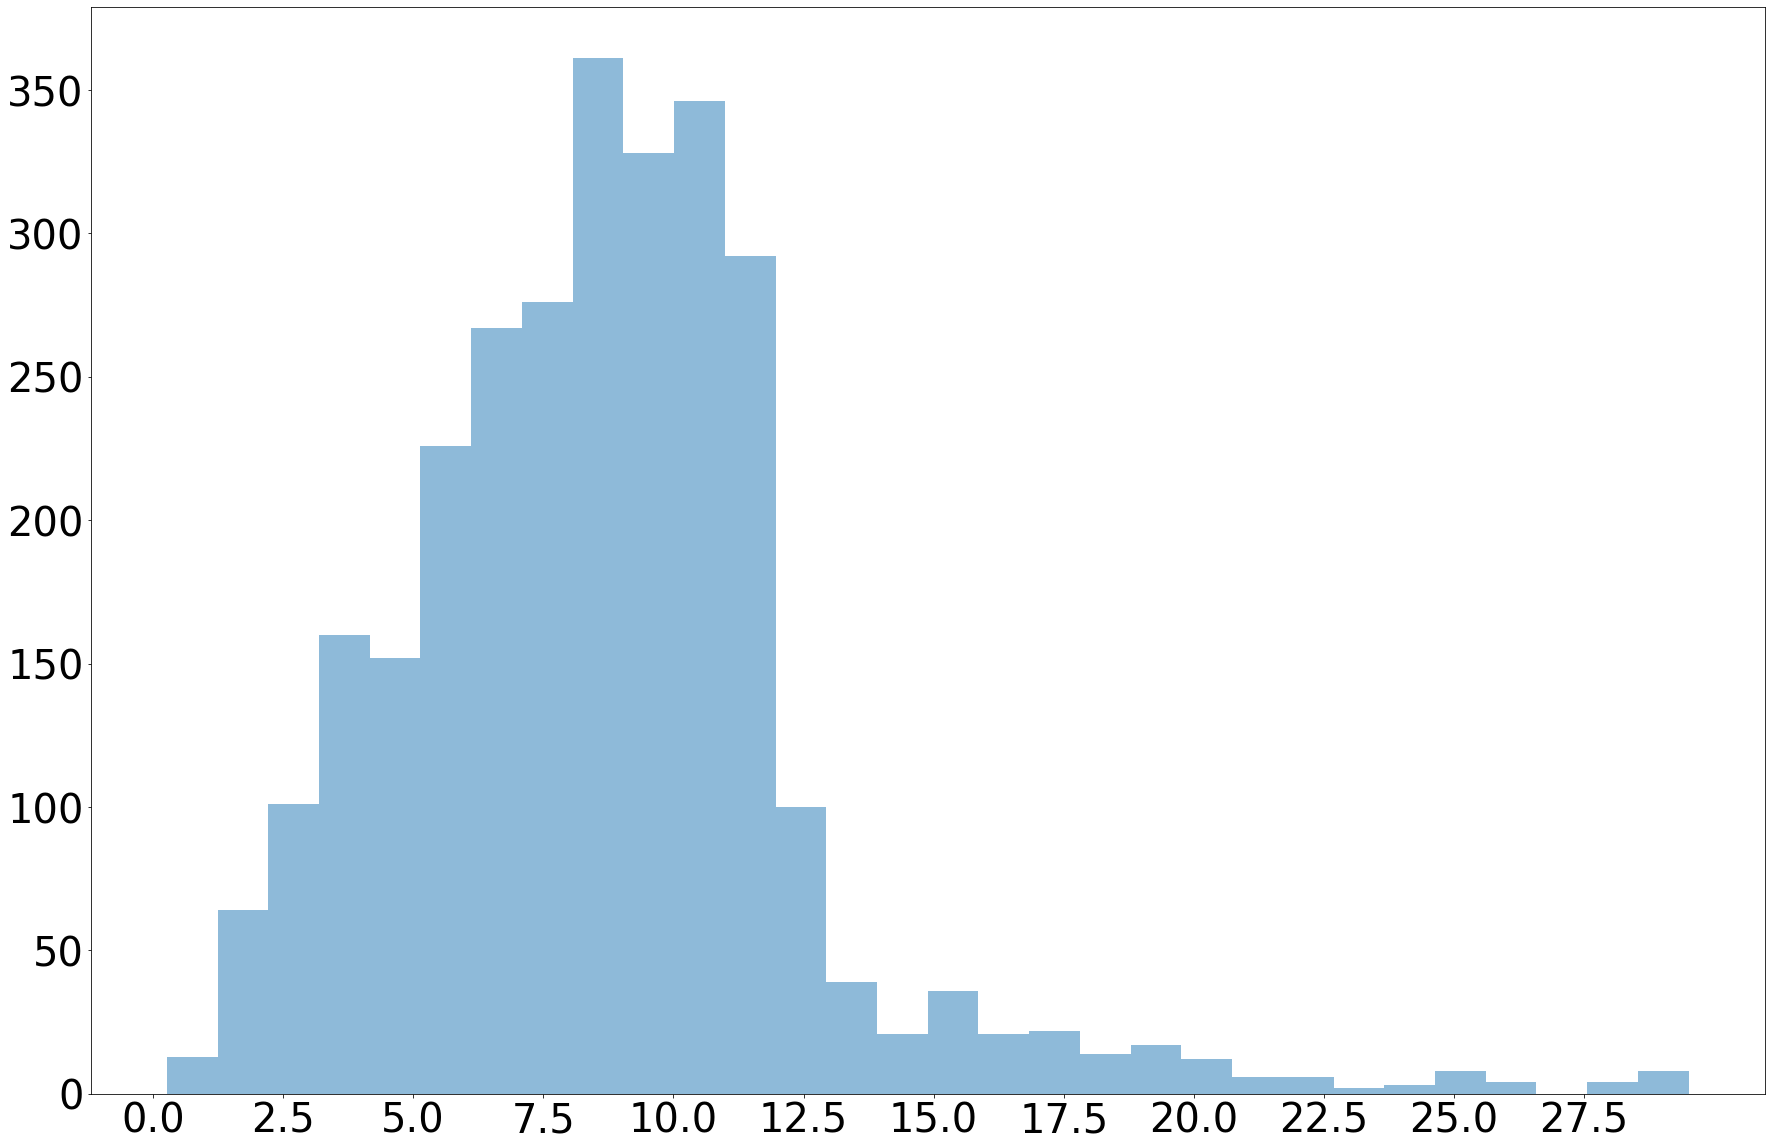

In [261]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(30, 20)
# Visualise by area of bins
ax.hist(np.array(sasa35flist)*100,alpha=0.5,bins=30);
ax.set_xticks(np.arange(0,30,2.5));
ax.set_xticklabels(np.arange(0,30,2.5),fontsize=40);
ax.set_yticklabels(np.arange(0,400,50),fontsize=40);

In [175]:
l = "PUNOHVAFQIIDRY-UHFFFAOYSA-N"
comps = ["ligand_modified", "binding_site"]
path = f"/home/kate/workspace/EPHB4/{l}/"
PDB_file1 = f"{path}/{comps[0]}.pdb"
PDB_file2 = f"/home/kate/workspace/EPHB4/{comps[1]}.pdb"

In [9]:
id = "4llx"
comps = ["ligand_modified", "binding_site"]
path = f"/home/kate/workspace/hunter_scoring/input_data/{id}"
PDB_file1 = f"{path}/{comps[0]}.pdb"
PDB_file2 = f"{path}/{comps[1]}.pdb"

In [20]:
self = Scoring(PDB_file1, PDB_file2, protein_host=True, max_aip_dist=0.18, solvent="water")

/home/kate/anaconda3/envs/scoring/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/kate/anaconda3/envs/scoring/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [29]:
self.interaction_df.sort_values("AIP_Distance")#[["L_type", "R_type", "L_value", "R_value", "Frac", "ddG_sc"]]

,L,R,Atom_Distance,L_AIP,R_AIP,AIP_Distance,Frac,L_type,R_type,L_value,R_value,ddG,ddG_sc,s35_L,s35_R,s70_L,s70_R
15,16.0,665.0,0.202172,41.0,680.0,0.018964,1.0,H.N,O.2.am,2.59,-7.46,0.787887,0.787887,0.049211,0.130072,0.017692,0.079273
4,6.0,726.0,0.368215,28.0,744.0,0.056210,0.5,C.ar,C.ar,-1.80,-1.56,-1.239202,-0.619601,0.041720,0.067597,0.011581,0.005791
16,5.0,672.0,0.203554,24.0,688.0,0.060344,1.0,N.ar,H.N,-7.59,2.70,0.463054,0.463054,0.041282,0.035927,0.015268,0.022229
0,1.0,727.0,0.395989,19.0,747.0,0.060776,0.5,C.ar,C.ar,-1.81,-1.56,-1.221784,-0.610892,0.050698,0.049113,0.008686,0.006514
1,2.0,725.0,0.389566,20.0,745.0,0.080681,0.5,C.ar,C.ar,-1.47,-1.55,-1.796847,-0.898424,0.073406,0.039608,0.025334,0.016648
3,5.0,724.0,0.359754,26.0,742.0,0.093427,0.5,N.ar,C.ar,-0.78,-1.53,-2.741552,-1.370776,0.041282,0.054923,0.015268,0.010134
7,6.0,475.0,0.294691,27.0,483.0,0.104672,0.5,C.ar,H.soft,-1.85,0.34,-3.103120,-1.551560,0.041720,0.032002,0.011581,0.005444
5,14.0,723.0,0.298872,39.0,739.0,0.107674,0.5,H.soft,C.ar,0.87,-1.52,-3.233627,-1.616813,0.092987,0.027461,0.091183,0.000724
8,8.0,475.0,0.263510,32.0,483.0,0.117020,0.5,N.ar,H.soft,-0.81,0.34,-4.069678,-2.034839,0.096627,0.032002,0.069343,0.005444
9,13.0,666.0,0.309279,40.0,678.0,0.143743,0.5,H.soft,N.pl3.am,0.87,-0.26,-3.625472,-1.812736,0.094799,0.052169,0.056706,0.015268


In [27]:
#self.interaction_df
create_ip_vis(self, f"{id}")

In [28]:
frac = self.interaction_df.Frac
dG4 = ([-sc(j[10], None, "water")*frac[i] for i,j in self.interaction_df.iterrows()])
dG6 = ([sc(j[10], None, "noble")*frac[i] for i,j in self.interaction_df.iterrows()])
prot_phtr = 0
for i,j in enumerate(self.interaction_df.R):
    a = self.Atom_R[j]
    if a.sasa35f < 0.08 and a.polar == False:
        prot_phtr += dG4[i]
        prot_phtr += dG6[i]
print(-prot_phtr +  sum([i for i in self.interaction_df.ddG_sc if i < 5]))

-19.700608276250563


In [12]:
for a in self.Atom_R.values():
    print(a.index, a.type, a.sasa35, a.sasa70, a.polar)

146 N.pl3.am 0.17011724 0.20421137 False
147 X 0.016899256 0.010857346 False
148 C.2 0.017427357 0.0057905843 False
149 O.2.am 0.14105812 0.102187976 True
150 X 0.025876986 0.010133523 False
151 X 0.026405087 0.0188194 False
152 X 0.02746129 0.00723823 False
153 X 0.030629901 0.021714691 False
154 X 0.034477092 0.0254469 False
155 H.soft 0.08725114 0.09798753 False
156 H.soft 0.05464518 0.04627189 False
157 H.soft 0.053437553 0.04944741 False
158 H.soft 0.079703465 0.06305679 False
159 H.soft 0.10144077 0.11794795 False
160 H.soft 0.04105936 0.024496883 False
161 H.soft 0.10687511 0.12611358 False
162 H.soft 0.10053506 0.11749431 False
163 H.soft 0.10476176 0.12565993 False
164 H.N 0.122876175 0.1569615 True
165 H.N 0.13404673 0.17782922 True
166 H.N 0.12770669 0.15287869 True
167 H.N 0.11351706 0.14788859 True
189 N.pl3.am 0.018599484 0.0019085174 False
190 X 0.0 0.0 False
191 C.2 0.019539764 0.0 False
192 O.2.am 0.18895635 0.17712583 True
193 X 0.0 0.0 False
194 X 0.05122587 0.036191

In [50]:
for a in self.AIP_L.values():
    print(a.index, a.atom, a.type, a.sasa_b35, a.sasa_b70)

25 1 S.3 0.01742641541583479 0.0015707964077591896
26 1 S.3 0.03485283083166958 0.0007853982038795948
27 1 S.3 0.0005808805138611597 0.0
28 1 S.3 0.01742641541583479 0.0054977874271571634
29 2 C.ar 0.022708374720353346 0.01302881445735693
30 2 C.ar 0.01161823822901799 0.0
31 3 N.ar 0.024496882265766726 0.01081493217498064
32 3 N.ar 0.02767240404095871 0.017812829464673996
33 3 N.ar 0.016331254843844484 0.0006361724808812141
34 4 N.ar 0.03493074079354604 0.022266037666644804
35 4 N.ar 0.019506777326265972 0.0025446900190451206
36 4 N.ar 0.004082813858985901 0.0
37 5 C.ar 0.04119193670542344 0.0028952921275049444
38 5 C.ar 0.019539764847444453 0.0
39 6 N.3.aniline 0.06668595969676971 0.04644059017300606
40 7 N.ar 0.03402344739207855 0.017812829464673996
41 7 N.ar 0.00453645965227714 0.0
42 7 N.ar 0.02041406843524713 0.012723449617624283
43 8 C.ar 0.017955458949546556 0.0
44 8 C.ar 0.021124069352407713 0.011581168510019777
45 9 C.ar 0.02323647661180031 0.010857345536351204
46 9 C.ar 0.020

In [83]:
prot_phtr

-8.190372679329357

In [143]:
a = self.AIP_R[389]
print(a.index, a.atom, a.type, a.sasa_b35, a.sasa_b70)

389 344 C.2 0.02376457831511895 0.002895292072069077


In [20]:
dG1 = 0
for i, r in self.interaction_df.iterrows():
    if r.L_type == "H.soft" and r.R_type == "H.soft":
        dG1 += r.ddG_sc * 0.75
    else:
        dG1 += r.ddG_sc
dG1

-7.442406049640356

In [47]:
frac = self.interaction_df.Frac
dG1 = sum(self.interaction_df.ddG_sc)
dG2 = [bc(j[10], j[9], "mesitylene")*frac[i] for i,j in self.interaction_df.iterrows()]
dG3 = np.array([j[10]*j[9]*j[6] for _,j in self.interaction_df.iterrows()])
dG4 = np.array([-sc(j[10], j[9], "chloroform")*frac[i] for i,j in self.interaction_df.iterrows()])
dG5 = sum([sc(j[10], j[9], "n-hexadecane")*frac[i] for i,j in self.interaction_df.iterrows()])
dG6 = np.array([sc(j[9], j[10], "noble")*frac[i] for i,j in self.interaction_df.iterrows()])

In [48]:
print(dG2)

[-1.2863380872825236, -1.2545447035524782, -1.0034435971738151, -1.0646390421135168, -1.3786413216238893, -1.1087896397550083, -2.061768048089665, -1.4943798148388647, -1.2620523344869703, -1.343162527734008, -1.563017497139385, -1.3123365492303756, -1.660819587496639, -1.2988656631232347, -1.348921144063591, -1.3610064063710534, -1.332547784735619, -1.1672082311322396, -1.6133776927150456, -1.2883061212173557, -1.7624757061136531, -1.5402589545315926, -1.0176032059536517, -0.8628639371914808, -1.3374796323833253, -1.3811366651496009]


# Guest-host complexes

In [46]:
self.interaction_df#[["L_type", "R_type", "L_value", "R_value", "Frac", "ddG_sc"]]

,L,R,Atom_Distance,L_AIP,R_AIP,AIP_Distance,Frac,L_type,R_type,L_value,R_value,ddG,ddG_sc,s35_L,s35_R,s70_L,s70_R
0,6.0,72.0,0.285997,20.0,302.0,0.048538,0.5,H.soft,C.ar,1.11,-0.09,0.258217,0.129108,0.013586,0.034855,0.000454,0.033296
1,6.0,66.0,0.291357,20.0,293.0,0.094082,0.5,H.soft,C.ar,1.11,0.06,0.322496,0.161248,0.013586,0.041720,0.000454,0.039086
2,4.0,103.0,0.372354,15.0,344.0,0.051252,0.5,S.3,C.ar,-2.94,-0.58,1.108245,0.554122,0.077257,0.040136,0.008639,0.015924
3,4.0,104.0,0.350378,15.0,346.0,0.124990,0.5,S.3,C.ar,-2.94,-0.42,0.955232,0.477616,0.077257,0.015315,0.008639,0.007962
4,4.0,102.0,0.403369,16.0,343.0,0.140422,0.5,S.3,C.ar,1.02,-0.54,0.112182,0.056091,0.077257,0.036439,0.008639,0.018819
5,4.0,84.0,0.346266,17.0,326.0,0.083712,0.5,S.3,C.ar,1.24,0.75,0.930512,0.465256,0.077257,0.039608,0.008639,0.041982
6,4.0,79.0,0.355959,14.0,315.0,0.079847,0.5,S.3,C.ar,-2.87,1.07,-0.720176,-0.360088,0.077257,0.040664,0.008639,0.042706
7,4.0,81.0,0.389033,14.0,319.0,0.138362,0.5,S.3,C.ar,-2.87,0.37,0.116585,0.058292,0.077257,0.057563,0.008639,0.038363
8,9.0,31.0,0.291115,23.0,225.0,0.062522,0.5,H.soft,C.ar,0.89,0.03,0.190582,0.095291,0.049211,0.034855,0.000454,0.034744
9,9.0,32.0,0.304741,23.0,226.0,0.077322,0.5,H.soft,C.ar,0.89,-0.43,0.099638,0.049819,0.049211,0.030102,0.000454,0.016648


In [6]:
#comps = ["guestCOMe", "host"]
comps = ["comp25", "comp26"]
#path = "/home/kate/workspace/Calixpyrrole/"
#path = "/home/kate/workspace/MACROCYCLE/AIP/water/"
#path = "/media/kate/My Passport/KatarzynaZatorPhDWork/ZIPPERS_2/AIP/"
#path = "/media/kate/My Passport/KatarzynaZatorPhDWork/EtoF3/AIP"
#path = "/home/kate/workspace/EtoF2/AIP"
#path = "/home/kate/workspace/EtoF3/AIP"
path = "/media/kate/My Passport/KatarzynaZatorPhDWork/Datasets/S30L/"
#path = "/media/kate/My Passport/KatarzynaZatorPhDWork/Datasets/S30L/CrystHG/AIP"

PDB_file1 = f"{path}/{comps[0]}/{comps[0]}.pdb"
PDB_file2 = f"{path}/{comps[1]}/{comps[1]}.pdb"
PDB_preprocess(PDB_file1, PDB_file2)

FileNotFoundError: [Errno 2] No such file or directory: '/media/kate/My Passport/KatarzynaZatorPhDWork/Datasets/S30L//comp25/comp25.pdb'

In [31]:
path = "/home/kate/workspace/hunter_scoring/"
PDB_file1 = f"{path}A/compA.pdb"
PDB_file2 = f"{path}B/compB.pdb"
AIP_file1 = f"{path}A/ssipA.xml"
AIP_file2 = f"{path}B/ssipB.xml"

In [35]:
self = Scoring(PDB_file1, PDB_file2, AIP_file1, AIP_file2,  max_aip_dist=0.18, solvent="chloroform")

In [37]:
list(self.interaction_df.L_AIP)

[32.0,
 33.0,
 33.0,
 35.0,
 25.0,
 24.0,
 31.0,
 22.0,
 23.0,
 30.0,
 34.0,
 15.0,
 18.0,
 19.0,
 14.0]

In [29]:
TAB = "\\begin{table}[H]\n\\centering\n\\begin{tabular}{p{0.05\\textwidth}p{0.12\\textwidth}p{0.11\\textwidth}p{0.05\\textwidth}p{0.11\\textwidth}p{0.09\\textwidth}p{0.05\\textwidth}p{0.1\\textwidth}}\nGuest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \\textit{f} & $\Delta\Delta G$ (kJ/mol) \\\\\n"
for row in self.interaction_df.values.tolist():
    TAB += f"{int(row[0])} & {row[7]} & {round(row[9],2)} & {int(row[1])} & {row[8]} & {round(row[10],2)} & {row[6]} & {round(row[12],2)} \\\\\n"
TAB += "\end{tabular}\n\caption{}\n\label{A2:1t}\n\end{table}"

In [30]:
print(TAB)

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
63 & H.N & 3.17 & 214 & C.2 & 0.64 & 0.5 & 0.96 \\
20 & N.ar & -1.28 & 216 & N.pl3.am & 0.64 & 0.5 & 0.04 \\
72 & H.soft & 1.11 & 231 & H.soft & 0.85 & 1.0 & 0.71 \\
2 & N.ar & -1.0 & 219 & N.pl3.am & 0.58 & 0.5 & 0.02 \\
2 & N.ar & -3.47 & 228 & H.N & 3.59 & 1.0 & -6.36 \\
20 & N.ar & -3.1 & 227 & H.N & 3.3 & 1.0 & -4.75 \\
59 & H.N & 3.58 & 218 & O.2.am & -4.61 & 1.0 & -9.07 \\
50 & H.N & 3.84 & 218 & O.2.am & -4.42 & 1.0 & -9.59 \\
\end{tabular}
\caption{}
\label{A2:1t}
\end{table}


\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
3 & C.ar & -3.27 & 36 & C.ar & -1.52 & 0.5 & 1.72 \\
4 & C.ar & -2.17 & 37 & C.ar & -1.65 & 0.5 & 1.19 \\
5 & C.ar & -2.03 & 40 & C.ar & -1.74 & 0.5 & 1.17 \\
6 & C.ar & -2.01 & 42 & C.ar & -1.71 & 0.5 & 1.15 \\
7 & C.ar & -2.02 & 44 & C.ar & -1.86 & 0.5 & 1.21 \\
8 & C.ar & -2.15 & 45 & C.ar & -1.81 & 0.5 & 1.25 \\
\end{tabular}
\caption{}
\label{A2:1t}
\end{table}

In [31]:
with open("Output.txt", "w") as text_file:
    text_file.write(TAB)

In [42]:
-sc(-3.24, None, "water")

3.2800996476177953

In [53]:
self.interaction_df = self.interaction_df.iloc[np.r_[0:15,16:16],:]
self.interaction_df.reset_index(drop=True, inplace=True)
self.interaction_df

,L,R,Atom_Distance,L_AIP,R_AIP,AIP_Distance,Frac,L_type,R_type,L_value,R_value,ddG,ddG_sc,s35_L,s35_R,s70_L,s70_R
0,15.0,227.0,0.306512,58.0,242.0,0.106432,0.5,C.ar,H.soft,-1.51,0.34,-3.510856,-1.755428,0.039080,0.043173,0.005067,0.012702
1,16.0,1140.0,0.288551,60.0,1154.0,0.118744,0.5,C.ar,H.soft,-1.38,0.84,-3.365524,-1.682762,0.048585,0.023247,0.004343,0.000000
2,1.0,1401.0,0.286284,30.0,1420.0,0.107211,0.5,C.ar,H.soft,-1.24,0.94,-3.339266,-1.669633,0.048585,0.042569,0.019543,0.005897
3,5.0,1401.0,0.332513,37.0,1420.0,0.110581,0.5,C.ar,H.soft,-0.87,0.94,-3.485711,-1.742855,0.036967,0.042569,0.005791,0.005897
4,1.0,492.0,0.273866,29.0,509.0,0.117117,0.5,C.ar,H.soft,-1.19,0.97,-3.325422,-1.662711,0.048585,0.042267,0.019543,0.022229
5,2.0,1139.0,0.297725,32.0,1150.0,0.131744,0.5,C.ar,H.soft,-0.34,0.65,-3.941649,-1.970824,0.048057,0.022341,0.033296,0.000000
6,3.0,1139.0,0.280702,34.0,1150.0,0.123758,0.5,C.ar,H.soft,-0.96,0.65,-3.792073,-1.896036,0.061260,0.022341,0.050668,0.000000
7,4.0,1142.0,0.262535,36.0,1152.0,0.153959,0.5,C.ar,H.soft,-2.06,0.81,-2.749161,-1.374581,0.077103,0.034116,0.059353,0.004536
8,23.0,224.0,0.260917,68.0,239.0,0.129027,1.0,H.soft,H.soft,0.97,0.64,-2.676548,-2.676548,0.060985,0.064608,0.018599,0.013156
9,25.0,1174.0,0.348215,70.0,1189.0,0.142440,0.5,H.soft,C.ar,1.28,-1.53,-2.688553,-1.344277,0.051022,0.068653,0.006351,0.006514


# Testing new ideas

In [8]:
# looking for a way to discount C.ar - C.ar 90 degree interaction determine angle between the Atom-AIP vectors
final_df = self.interaction_df
L_xyz = [self.Atom_L[int(L)].xyz for L in final_df["L"]]
R_xyz = [self.Atom_R[int(R)].xyz for R in final_df["R"]]
vector_L = [-self.AIP_L[int(L)].xyz + L_xyz[i] for i, L in enumerate(final_df["L_AIP"])]
vector_R = [-self.AIP_R[int(R)].xyz + R_xyz[i] for i, R in enumerate(final_df["R_AIP"])]
nv_L = np.array([L/np.linalg.norm(L) for L in vector_L])
nv_R = np.array([R/np.linalg.norm(R) for R in vector_R])
angle = np.array([np.arccos(np.dot(L, R)) for L, R in zip(nv_L, nv_R)]) * 180 / np.pi

In [26]:
a,b,c,d,e = get_desolvated_AIPs(self, "chloroform", probe_radius=0.2, frac_to_desolv=0.35)

# Compilations

In [14]:
for i in ZIP:
    comps = i[0:2]
    PDB_file1 = f"{path}/{comps[0]}/{comps[0]}.pdb"
    PDB_file2 = f"{path}/{comps[1]}/{comps[1]}.pdb"
    PDB_preprocess(PDB_file1, PDB_file2)
    self = Scoring(PDB_file1, PDB_file2, max_aip_dist=0.1, solvent="chloroform", branch=True)
    all_atoms = list(self.state.ligand_atom_indices)+list(self.state.residue_atom_indices)
    traj = self.mdTrajectory.atom_slice(all_atoms)
    yy = get_sasa_per_AIP(self, traj, probe_radius=0.2, L=True, only=False)
    yy = get_sasa_per_AIP(self, traj, probe_radius=0.2, L=False, only=False)
    Ltraj = self.mdTrajectory.atom_slice(list(self.state.ligand_atom_indices))
    Rtraj = self.mdTrajectory.atom_slice(list(self.state.residue_atom_indices))
    xx = get_sasa_per_AIP(self, Ltraj, probe_radius=0.2, L=True, only=True)
    xx = get_sasa_per_AIP(self, Rtraj, probe_radius=0.2, L=False, only=True)
    print(comps, sum([round(i.sasa_f - i.sasa_b, 4) for i in self.AIP_R.values()]))

KeyError: 'L_AIP'

In [4]:
path = "/home/kate/workspace/Calixpyrrole"
PDB_file2 = f"{path}/host/host.pdb"
for X in CAL: #for calixpyrroles
    PDB_file1 = f"{path}/guest{X}/guest{X}.pdb"
    self = Scoring(PDB_file1, PDB_file2, max_aip_dist=0.15, solvent="water", branch=True)
    dG1 = sum(self.interaction_df.ddG_sc)
    frac = self.interaction_df.Frac
    dG3 = sum([j[10]*j[9]*frac[i] for i,j in self.interaction_df.iterrows()])
    dG4 = -sum([sc(j[10], j[9], "water")*frac[i] for i,j in self.interaction_df.iterrows()])
    dG6 = sum([sc(j[10], j[9], "noble")*frac[i] for i,j in self.interaction_df.iterrows()])
    print(dG1, dG3+dG4+dG6)

-16.131637535399836 -9.395664861090157
-18.574093584516387 -11.347876780993019
-19.994826554248974 -9.67234430338123
-24.07468400021873 -22.80167336294566
-22.878946264220737 -25.304734828917823
-15.941979926134199 -8.931437289611363
-24.044322584986045 -21.454374818538998
-20.759619086953155 -20.282309649806578
-25.197571570867872 -18.011779206483943
-20.510506215577138 -14.395708388943058
-18.97450059810884 -16.124430567425797
-21.17347134139414 -18.948566604494136
-23.040557345179007 -21.158611245592702


In [11]:
for i in ZIP:
    path = "/media/kate/My Passport/KatarzynaZatorPhDWork/Datasets/S30L"
    comps = i[0:2]
    PDB_file1 = f"{path}/guest{X}/guest{X}.pdb"
    PDB_file2 = f"{path}/host/host.pdb"
    self = Scoring(PDB_file1, PDB_file2, max_aip_dist=0.15, solvent="chloroform", branch=True)
    TAB = "\\begin{table}[H]\n\\centering\n\\begin{tabular}{p{0.05\\textwidth}p{0.12\\textwidth}p{0.11\\textwidth}p{0.05\\textwidth}p{0.11\\textwidth}p{0.09\\textwidth}p{0.05\\textwidth}p{0.1\\textwidth}}\nGuest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \\textit{f} & $\Delta\Delta G$ (kJ/mol) \\\\\n"
    for row in self.interaction_df.values.tolist():
        TAB += f"{int(row[1])} & {row[8]} & {round(row[10],2)} & {int(row[0])} & {row[7]} & {round(row[9],2)} & {row[6]} & {round(row[12],2)} \\\\\n"   
    TAB += "\end{tabular}\n\caption{}\n\label{A2:1t}\n\end{table}\n"
    print(TAB)

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
115 & C.ar & -1.88 & 10 & C.ar & -1.18 & 0.5 & 0.87 \\
122 & C.ar & -1.85 & 7 & C.ar & -1.18 & 0.5 & 0.86 \\
130 & C.ar & -1.85 & 18 & H.soft & 1.15 & 0.5 & -0.09 \\
121 & C.ar & -1.46 & 8 & C.ar & -1.18 & 0.5 & 0.7 \\
118 & C.ar & -1.77 & 9 & C.ar & -1.16 & 0.5 & 0.82 \\
112 & C.ar & -1.74 & 8 & C.ar & -1.16 & 0.5 & 0.8 \\
111 & C.ar & -1.79 & 9 & C.ar & -1.07 & 0.5 & 0.79 \\
105 & C.ar & -1.47 & 16 & H.soft & 1.14 & 0.5 & -0.06 \\
106 & C.ar & -1.74 & 16 & H.soft & 1.14 & 0.5 & -0.08 \\
126 & C.ar & -1.77 & 11 & C.ar & -1.07 & 0.5 & 0.78 \\
113 & C.ar & -1.47 & 7 & C.ar & -1.18 & 0.5 & 0.7 \\
113 & C.ar & -1.47 & 21 & H.soft & 1.13 & 0.5 & -0.06 \\
107 & C.ar & -1.79 & 17 & H.soft 

\begin{table}[H]
\centering
\begin{tabular}{p{0.05\textwidth}p{0.12\textwidth}p{0.11\textwidth}p{0.05\textwidth}p{0.11\textwidth}p{0.09\textwidth}p{0.05\textwidth}p{0.1\textwidth}}
Guest & Guest atom type & Guest AIP value & Host & Host atom type & Host AIP value & \textit{f} & $\Delta\Delta G$ (kJ/mol) \\
130 & C.ar & -1.88 & 10 & C.ar & -0.4 & 0.5 & 0.53 \\
145 & C.ar & -1.85 & 21 & H.soft & 1.4 & 0.5 & -0.2 \\
144 & C.ar & -1.46 & 26 & H.soft & 1.21 & 0.5 & -0.08 \\
133 & C.ar & -1.77 & 9 & C.ar & -0.6 & 0.5 & 0.58 \\
125 & C.ar & -1.81 & 12 & C.ar & -0.26 & 0.5 & 0.43 \\
128 & C.ar & -1.47 & 13 & C.2 & -0.87 & 0.5 & 0.58 \\
137 & C.ar & -1.85 & 7 & C.ar & -0.44 & 0.5 & 0.54 \\
180 & H.soft & 0.93 & 13 & C.2 & -0.91 & 0.5 & 0.0 \\
127 & C.ar & -1.74 & 8 & C.ar & -1.22 & 0.5 & 0.83 \\
126 & C.ar & -1.79 & 9 & C.ar & -0.5 & 0.5 & 0.54 \\
120 & C.ar & -1.47 & 19 & H.soft & 0.9 & 0.5 & 0.0 \\
121 & C.ar & -1.74 & 19 & H.soft & 0.9 & 0.5 & 0.01 \\
141 & C.ar & -1.77 & 11 & C.ar & -0.32 &

In [2]:
MAC = [["host",  "guest" ],["host2", "guest2"],["host3", "guest3"],["host4", "guest4"],["host5", "guest5"],
       ["host6", "guest6"],["host7", "guest7"],["host8", "guest8"]]

In [6]:
CAL = ["H","Me","NMe2","CF3","NO2","OMe","CHO","COMe","iPr","Et","F","Cl","Br"]

In [3]:
EtoF = [["comp100", "comp101"], ["comp102", "comp103"], ["comp104", "comp105"], ["comp106", "comp107"],
["comp108", "comp109"], ["comp110", "comp111"], ["comp112", "comp113"]]

In [2]:
EtF = [["comp1", "comp2"], ["comp3", "comp4"],["comp5", "comp6"], ["comp7", "comp8"],
["comp9", "comp10"],["comp11", "comp12"],["comp13", "comp14"], ["comp15", "comp16"],
["comp17", "comp18"],["comp19", "comp20"],["comp21", "comp22"], ["comp23", "comp24"],
["comp25", "comp26"],["comp27", "comp28"],["comp29", "comp30"],["comp31", "comp32"],
["comp33", "comp34"],["comp35", "comp36"],["comp37", "comp38"],["comp39", "comp40"],
["comp41", "comp42"],
["comp45", "comp46"], ["comp47", "comp48"],["comp49", "comp50"],["comp51", "comp52"],
["comp53", "comp54"], ["comp55", "comp56"],["comp57", "comp58"],["comp59", "comp60"],
["comp61", "comp62"], ["comp63", "comp64"],["comp65", "comp66"],["comp67", "comp68"]]

In [12]:
ZIP = [["comp1", "comp2"], ["comp3", "comp4"],["comp5", "comp6"], ["comp7", "comp8"],
["comp9", "comp10"],["comp11", "comp12"],["comp13", "comp14"], ["comp15", "comp16"],
["comp17", "comp18"],["comp19", "comp20"],["comp21", "comp22"], ["comp23", "comp24"],
["comp25", "comp26"],["comp27", "comp28"],["comp29", "comp30"],["comp31", "comp32"],
["comp33", "comp34"],["comp35", "comp36"],["comp37", "comp38"],["comp39", "comp40"],
["comp41", "comp42"], ["comp43", "comp44"],["comp45", "comp46"], ["comp47", "comp48"]]